<a href="https://colab.research.google.com/github/keamanansiber/Maryam/blob/master/notebooks/Prototipe_3_TopicModeling_TransferLearning_SentenceBERT_25062022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers
!pip install umap-learn
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 4.4 MB 63.1 MB/s 
     |████████████████████████████████| 1.2 MB 43.3 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.1-py3-none-any.whl size=125774 sha256=d132c6497bfc301a87eb3cc91810ca3c8338f8db9a27526b866bd65db20be4ab
  Stored in directory: /root/.cache/pip/wheels/58/27/2f/708b4f002c226e57b6243769da345c650633175c7634f93365
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

In [2]:
# core/util/iris/topicmodeling.py

import pandas as pd
import numpy as np
import json

from sklearn.cluster import KMeans
import scipy
import matplotlib.pyplot as plt
import umap

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


class topicmodeling:


	def __init__(self, input_json):


		print("\n\n DATASET = reading json file")
		input_json = "mixed.json"

		with open(input_json) as json_file:
		  jsonfile = json.load(json_file)

		print("\n\n jsonfile = ")
		print(jsonfile)

		tmp = pd.DataFrame(jsonfile['results'])
		tmp['td'] = tmp['t'] + ' ' + tmp['d']
		self.corpus = tmp['td'].to_numpy()

		print("\n\n number of sentences = ")
		print(len(self.corpus))

		print("\n\n self.corpus[0] = ")
		print(self.corpus[0])

		print("\n\n all self.corpus = ")
		print(self.corpus)


		print("\n\n histogram of the number of words in each sentence")
		pd.Series([len(e.split()) for e in self.corpus]).hist()



	def run_topic_modeling(self, selected_pretrained_model):		


		print("\n\n TRANSFER LEARNING = model selection")
		# https://www.sbert.net/docs/pretrained_models.html

		pretrained_model = selected_pretrained_model
		print(pretrained_model)

		model = SentenceTransformer(pretrained_model)

		print(model)


		print("\n\n CORPUS EMBEDDING")
		corpus_embeddings = model.encode(self.corpus)

		print(corpus_embeddings.shape)
		print(corpus_embeddings)



		print("\n\n (I) Topic Modeling with SkLearn KMeans")
		K=5
		kmeans = KMeans(n_clusters=5, random_state=0).fit(corpus_embeddings)

		print(kmeans)


		print("\n\n corpus_labeled = ")

		corpus_labeled = pd.DataFrame({'ClusterLabel':kmeans.labels_, 'Sentence':self.corpus})
		print(corpus_labeled)


		print("\n\n frequency of cluster label = ")

		cls_dist=pd.Series(kmeans.labels_).value_counts()
		print(cls_dist)


		print("\n\n calculate distance of cluster's center point = ")

		distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_ , corpus_embeddings)
		print(distances)


		print("\n\n Cluster's center example = ")

		centers={}
		print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
		for i,d in enumerate(distances):
			ind = np.argsort(d, axis=0)[0]
			centers[i]=ind
			print(i,cls_dist[i], ind, self.corpus[ind] ,sep="\t\t")


		print("\n\n Visualization of the cluster points")

		X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
		labels= kmeans.labels_

		fig, ax = plt.subplots(figsize=(12, 8))
		plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
		for c in centers:
			plt.text(X[centers[c],0], X[centers[c], 1], "CLS-"+ str(c), fontsize=24) 
		plt.colorbar()



		print("\n\n (II) Topic Modeling with BERT")

		sentence_model = SentenceTransformer(pretrained_model)
		print(sentence_model)

		topic_model = BERTopic(embedding_model=sentence_model)
		print(topic_model)

		topics, _ = topic_model.fit_transform(self.corpus)
		print(topic_model.get_topic_info()[:6])


		print("\n\n corpus_labeled = ")

		corpus_labeled = pd.DataFrame({'ClusterLabel':topics, 'Sentence':self.corpus})
		print(corpus_labeled)


		print("\n\n topics for each cluster = ")

		i=0
		while i < len(topic_model.get_topic_info()):
			print("Cluster #" + str(i) + " = ")
			print(topic_model.get_topic(i))
			i+=1
		
		

In [3]:
# Use dataset from Mr. Khausik's work https://github.com/k4u5h1k/Doclustering/blob/main/mixed.json
jsonfile = "mixed.json"



 DATASET = reading json file


 jsonfile = 
{'results': [{'t': 'Movie Coverage - YouTube', 'a': 'https://www.youtube.com/channel/UCwYzZs_hwA6NdaQp6Hjhe5w', 'c': 'www.youtube.com › channel', 'd': 'The best of films and movie trailers. Pick your Favorite Genre in our playlists.Do you want your trailer featured on this channel ? Please feel free to conta...'}, {'t': 'Marvel Studios Celebrates The Movies - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI', 'c': 'www.youtube.com › watch', 'd': 'Duration:     3:11    Posted:     3 days ago               \xa0\xa0VIDEO'}, {'t': 'FRESH Movie Trailers - YouTube', 'a': 'https://www.youtube.com/c/FreshMovieTrailers', 'c': 'www.youtube.com › FreshMovieTrailers', 'd': "All NEW MOVIE TRAILERS are Here! Don't miss the latest movie trailers and weekly recaps.You want your trailer featured on the channel ? Fell free to reach\xa0..."}, {'t': 'Movie: The Movie - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3Dw3NwB9PLxss', 'c': 'www.y

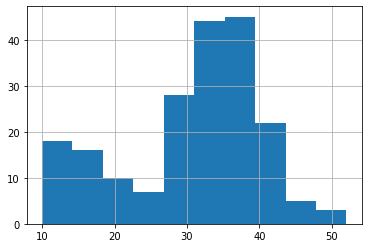

In [4]:
tm = topicmodeling(jsonfile)

https://www.sbert.net/docs/pretrained_models.html

all-mpnet-base-v2 

multi-qa-mpnet-base-dot-v1 

all-distilroberta-v1 

all-MiniLM-L12-v2 

multi-qa-distilbert-cos-v1 

all-MiniLM-L6-v2 

multi-qa-MiniLM-L6-cos-v1 

paraphrase-multilingual-mpnet-base-v2 

paraphrase-albert-small-v2 

paraphrase-multilingual-MiniLM-L12-v2 

paraphrase-MiniLM-L3-v2 

distiluse-base-multilingual-cased-v1 

distiluse-base-multilingual-cased-v2 

...



 TRANSFER LEARNING = model selection
paraphrase-distilroberta-base-v1


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 768)
[[-0.08396684 -0.00708914 -0.06282178 ...  0.21477976  0.10460781
   0.13799742]
 [-0.04522549  0.10183921  0.4076929  ...  0.27886808 -0.00113403
   0.3187846 ]
 [-0.14071551 -0.1693511  -0.06266584 ... -0.16775946 -0.03289073
   0.22983865]
 ...
 [-0.04209124  0.08936383  0.02402254 ...  0.72879833  0.37503076
   0.04131055]
 [ 0.03683152  0.12257855 -0.02820392 ...  0.37703583 -0.05632266
   0.4040222 ]
 [-0.21004134 -0.10027264 -0.32333714 ...  0.036526   -0.14582442
   0.27863666]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                    

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)




 (II) Topic Modeling with BERT
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)
BERTopic(calculate_probabilities=False, diversity=None, embedding_model=SentenceTransformer(...), hdbscan_model=HDBSCAN(...), language=None, low_memory=False, min_topic_size=10, n_gram_range=(1, 1), nr_topics=None, seed_topic_list=None, top_n_words=10, umap_model=UMAP(...), vectorizer_model=CountVectorizer(...), verbose=False)
   Topic  Count                          Name
0      0    167         0_music_and_the_movie
1      1     31  1_video_posted_duration_2021


 corpus_labeled = 
     ClusterLabel                                           Sentence
0               0  Movie Coverage - YouTube The best of films and...
1               1

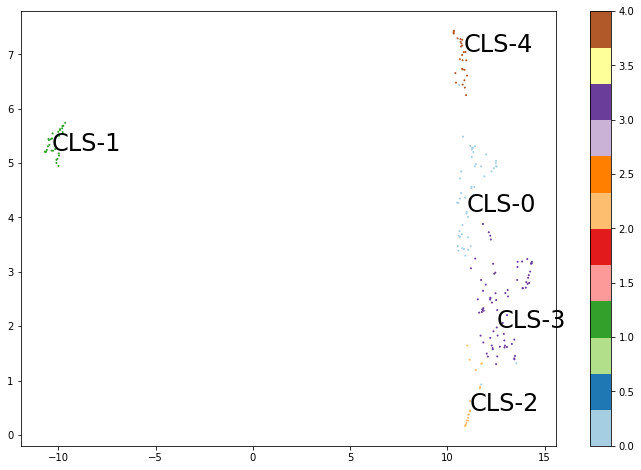

In [5]:
tm.run_topic_modeling("paraphrase-distilroberta-base-v1")



 TRANSFER LEARNING = model selection
all-mpnet-base-v2


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 768)
[[ 0.05145301 -0.01022881  0.03082184 ...  0.01119885 -0.03761183
  -0.00166425]
 [-0.01928567  0.02431043  0.01133575 ...  0.03461902 -0.00221807
   0.03917537]
 [ 0.03231348 -0.00261181  0.03026582 ...  0.01567243 -0.03847001
  -0.0041692 ]
 ...
 [-0.01034437  0.05862069 -0.00969467 ... -0.02647587 -0.05502504
  -0.0018026 ]
 [ 0.01938102  0.00048298  0.01075557 ...  0.00064679 -0.04864674
  -0.03783971]
 [-0.02952458 -0.04361947 -0.01305662 ... -0.02141356  0.00960957
  -0.04968072]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                   

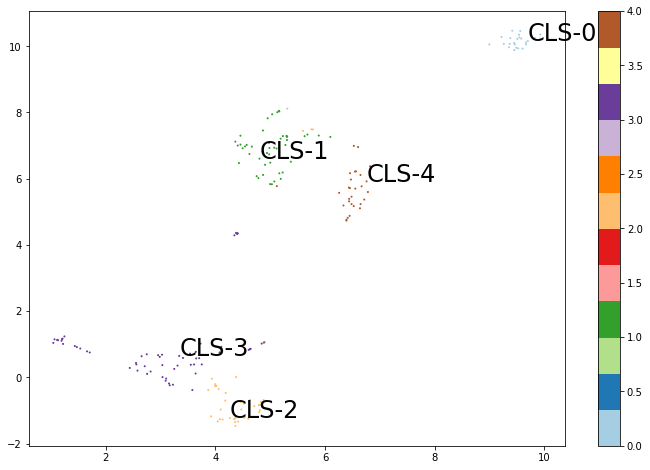

In [6]:
tm.run_topic_modeling("all-mpnet-base-v2")




 TRANSFER LEARNING = model selection
multi-qa-mpnet-base-dot-v1


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 768)
[[-0.08719093 -0.09222388 -0.30072948 ... -0.1198758  -0.05504007
  -0.03059253]
 [-0.11189084  0.00509684 -0.21910116 ...  0.05343901  0.13232227
   0.24217577]
 [ 0.01154924 -0.20345984 -0.27463108 ... -0.21685873 -0.1569639
  -0.02308424]
 ...
 [-0.25873184  0.30667132 -0.29625326 ... -0.38339126 -0.32474586
  -0.166391  ]
 [ 0.1543258   0.02759695 -0.21117464 ... -0.20428285 -0.14444532
  -0.28655446]
 [-0.03731726 -0.22140643 -0.3175415  ... -0.3133672  -0.12569983
  -0.19961213]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                       

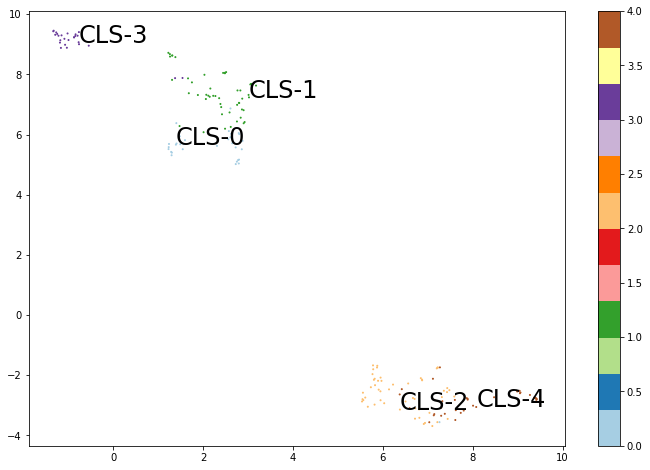

In [7]:
tm.run_topic_modeling("multi-qa-mpnet-base-dot-v1")




 TRANSFER LEARNING = model selection
all-distilroberta-v1


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 768)
[[-0.02762582 -0.02150511 -0.0076247  ...  0.05295808  0.02265443
  -0.00741357]
 [ 0.01566948 -0.0225105  -0.00276758 ...  0.00723857 -0.04532912
   0.02623625]
 [-0.03179809 -0.02315888 -0.03511279 ... -0.00215526  0.01395086
   0.00705856]
 ...
 [ 0.00043929 -0.0332068   0.01965796 ...  0.03830699  0.00435303
   0.00907093]
 [-0.00966193 -0.04732294 -0.00585388 ...  0.01068159  0.01899462
  -0.03015888]
 [-0.00211679 -0.04185452 -0.02396774 ...  0.06791319 -0.01996516
  -0.01094801]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                 

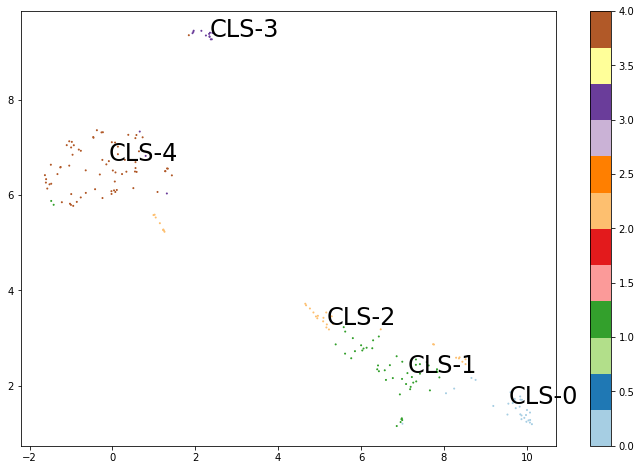

In [8]:
tm.run_topic_modeling("all-distilroberta-v1")




 TRANSFER LEARNING = model selection
all-MiniLM-L12-v2


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 384)
[[-0.05838409 -0.07595488  0.03429215 ...  0.03012071  0.00794821
   0.01487534]
 [-0.09550705  0.06166625  0.05742791 ... -0.06322233  0.00639283
   0.01635135]
 [-0.11292792 -0.07515694  0.07241593 ...  0.03853061  0.02245158
   0.03803165]
 ...
 [ 0.05738569  0.01953034  0.02961434 ...  0.00464016  0.07602818
   0.02152098]
 [-0.00081039 -0.08507389  0.05424273 ...  0.07358955  0.04880634
  -0.0454255 ]
 [-0.05380191 -0.11687589  0.03985381 ...  0.03816592  0.04368016
  -0.02204619]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                    

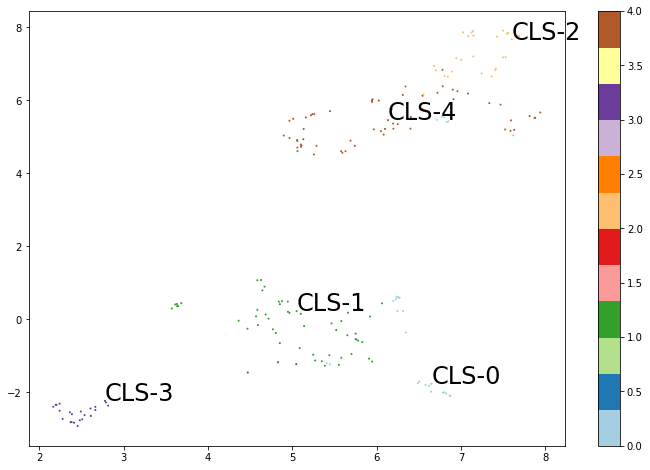

In [9]:
tm.run_topic_modeling("all-MiniLM-L12-v2")




 TRANSFER LEARNING = model selection
multi-qa-distilbert-cos-v1


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 768)
[[ 0.114754   -0.01999438  0.06611457 ... -0.00312071  0.04461312
   0.02768194]
 [ 0.01370675  0.01414788  0.09155377 ...  0.05837458  0.05764834
  -0.03059928]
 [ 0.10757127 -0.01374754  0.0936183  ... -0.00163881  0.01040119
   0.00950175]
 ...
 [ 0.0372591   0.006947   -0.08168211 ...  0.04856654  0.08349945
  -0.10324099]
 [ 0.03444853 -0.01354526  0.03290323 ... -0.02219605  0.02951758
  -0.10862263]
 [ 0.06666275 -0.04524035 -0.00064629 ...  0.08464681 -0.05216399
  -0.06528559]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel              

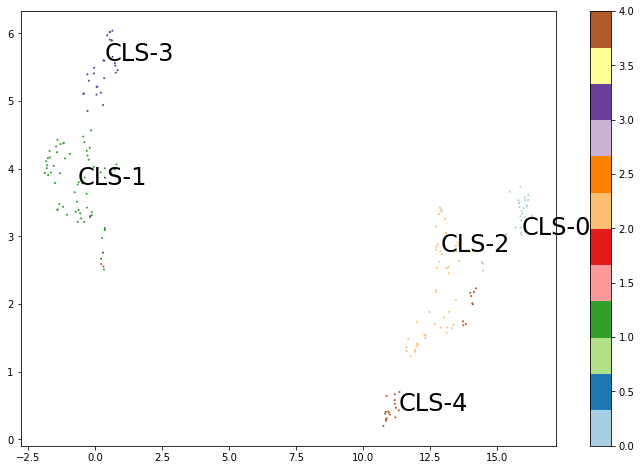

In [10]:
tm.run_topic_modeling("multi-qa-distilbert-cos-v1")




 TRANSFER LEARNING = model selection
all-MiniLM-L6-v2


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 384)
[[-0.10033726 -0.02874583 -0.01883646 ...  0.01184989  0.01279939
   0.059567  ]
 [-0.0250417  -0.05654237  0.00294158 ... -0.04522686 -0.00963761
   0.00938558]
 [-0.11121401 -0.09745104  0.0070742  ...  0.01379907  0.07576244
   0.01963471]
 ...
 [ 0.03181599 -0.08057419 -0.00900287 ... -0.06858025  0.04537711
   0.04986292]
 [-0.02371322 -0.04778148  0.02509811 ...  0.0069087   0.03079125
   0.08680858]
 [-0.08450995 -0.09962609 -0.00949476 ...  0.03756971  0.07360987
  -0.00908892]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                    

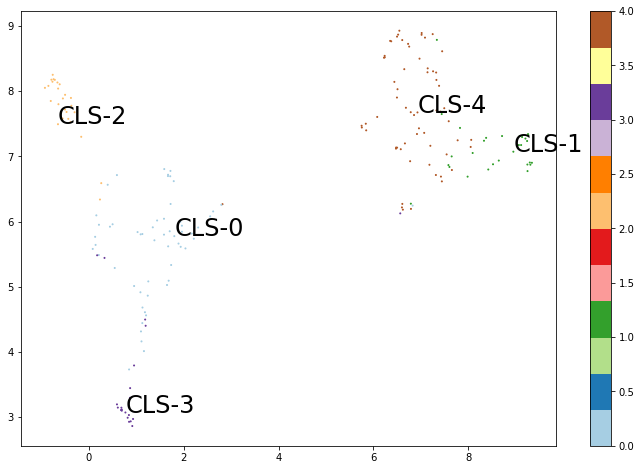

In [11]:
tm.run_topic_modeling("all-MiniLM-L6-v2")




 TRANSFER LEARNING = model selection
multi-qa-MiniLM-L6-cos-v1


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(198, 384)
[[-0.07148727 -0.13978891  0.01292963 ... -0.00511346  0.00247891
   0.01123758]
 [-0.06196366 -0.03639555 -0.03808131 ... -0.06479652 -0.06458233
  -0.01115748]
 [-0.07710776 -0.13812535  0.0268383  ...  0.04054431  0.01582982
  -0.0226046 ]
 ...
 [ 0.03042019 -0.03318838 -0.0030683  ... -0.0131228   0.03967999
  -0.00270025]
 [-0.02845701 -0.10963425  0.05870661 ...  0.04186681  0.03413403
  -0.02856068]
 [-0.10737667 -0.14940172  0.01580254 ...  0.08699358  0.1026876
  -0.01200029]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                     

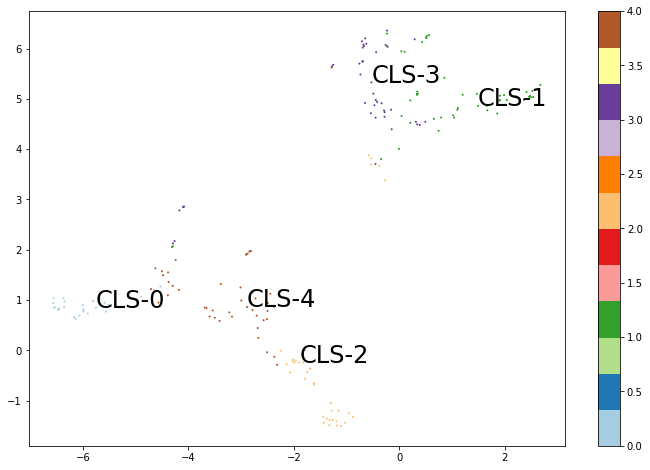

In [12]:
tm.run_topic_modeling("multi-qa-MiniLM-L6-cos-v1")




 TRANSFER LEARNING = model selection
paraphrase-multilingual-mpnet-base-v2


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 768)
[[-0.00541358  0.01884369 -0.0085235  ...  0.05575417 -0.16439681
   0.05716022]
 [-0.09821439 -0.08401989 -0.00307843 ...  0.14192519 -0.00654818
   0.0217103 ]
 [-0.02976213  0.10914297 -0.00658395 ...  0.05531111 -0.16891748
  -0.00988575]
 ...
 [-0.1250618   0.23489058 -0.0094006  ... -0.06152265 -0.09815534
  -0.06255329]
 [-0.12671447  0.12033787 -0.00495945 ... -0.02339173 -0.15708901
  -0.07619195]
 [-0.10271841  0.11905081 -0.00506405 ...  0.04015004 -0.1821831
   0.03379209]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                  

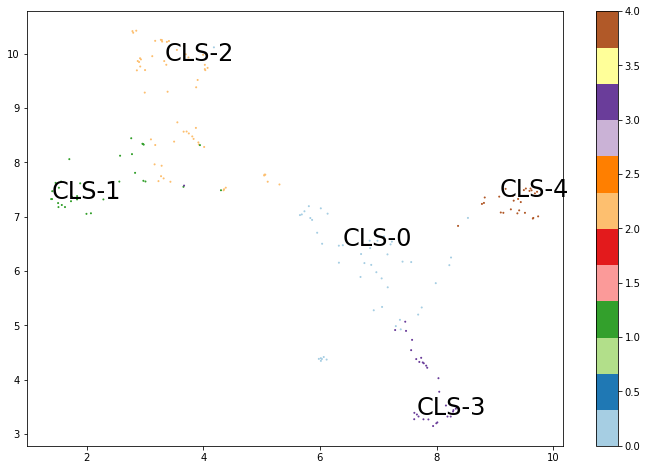

In [13]:
tm.run_topic_modeling("paraphrase-multilingual-mpnet-base-v2")




 TRANSFER LEARNING = model selection
paraphrase-albert-small-v2


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 100, 'do_lower_case': False}) with Transformer model: AlbertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 768)
[[-0.03566812 -0.3049124   0.03752476 ... -1.0238763  -0.16932939
  -0.05968314]
 [ 0.27389482  0.0872995  -0.81062454 ... -0.18219306  0.7562524
  -0.59897476]
 [-0.33650166 -0.10795537  0.18078625 ... -0.7549583  -1.0678129
  -0.62820095]
 ...
 [ 0.0951134  -0.35104993  0.12184973 ... -0.40462255  0.70211464
  -0.29285493]
 [ 0.04255269  0.3261971   0.00868305 ... -0.27556062  0.7727622
   0.34768233]
 [ 0.3450543  -0.19932933  0.09124439 ...  0.10581522  0.39551333
   0.31759205]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                        

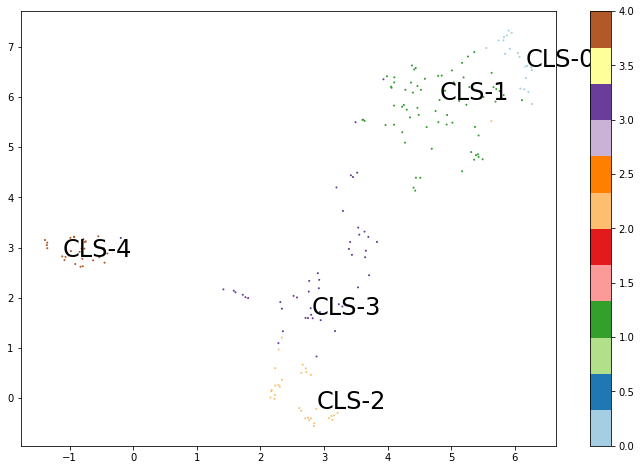

In [14]:
tm.run_topic_modeling("paraphrase-albert-small-v2")




 TRANSFER LEARNING = model selection
paraphrase-multilingual-MiniLM-L12-v2


Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 384)
[[-0.1486769  -0.48745546  0.08902685 ... -0.02559501  0.00528466
  -0.03545449]
 [-0.046957   -0.02695149  0.13281807 ... -0.39674556 -0.03230055
  -0.1530715 ]
 [-0.22189276 -0.5859293   0.08341265 ...  0.10861066 -0.14183313
  -0.11040126]
 ...
 [ 0.0100976  -0.29417813 -0.27316812 ... -0.17803484  0.42116502
   0.10153371]
 [-0.05833644 -0.17418166  0.05968085 ... -0.15430254  0.15784118
  -0.03784102]
 [-0.03039787 -0.37129584 -0.06642521 ...  0.23169546 -0.09491406
  -0.08209639]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                       

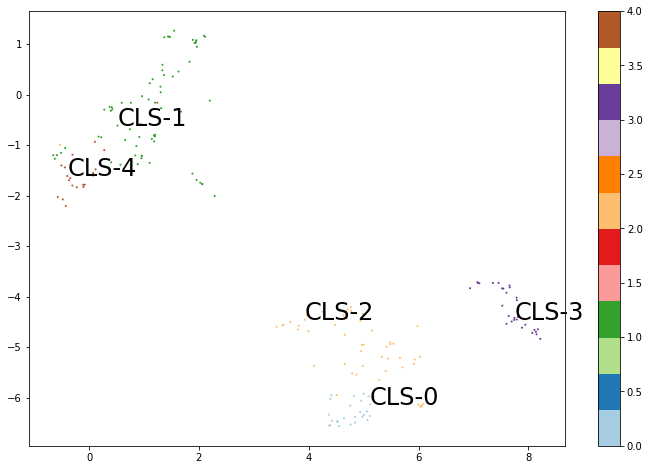

In [15]:
tm.run_topic_modeling("paraphrase-multilingual-MiniLM-L12-v2")




 TRANSFER LEARNING = model selection
paraphrase-MiniLM-L3-v2


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


 CORPUS EMBEDDING
(198, 384)
[[ 0.04868627 -0.5198242   0.20815551 ...  0.11389073 -0.20266502
  -0.21124154]
 [-0.2593017  -0.09128396  0.05809623 ...  0.03113109 -0.04548452
  -0.1382591 ]
 [ 0.09031255 -0.53597015  0.3936999  ...  0.19500722 -0.11900671
  -0.2971735 ]
 ...
 [ 0.09349453 -0.19868407  0.07483069 ...  0.06512949  0.32912987
  -0.27029848]
 [-0.31995976 -0.04499717 -0.11950946 ... -0.00923197  0.19908012
  -0.2762793 ]
 [-0.1640113  -0.08673341  0.10381262 ...  0.28660303  0.06328042
  -0.17718682]]


 (I) Topic Modeling with SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 
     ClusterLabel                                       

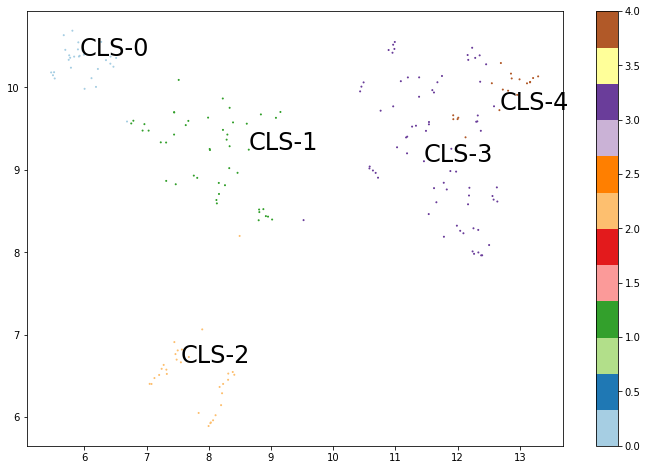

In [16]:
tm.run_topic_modeling("paraphrase-MiniLM-L3-v2")




 TRANSFER LEARNING = model selection
distiluse-base-multilingual-cased-v1


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)


 CORPUS EMBEDDING
(198, 512)
[[-0.07339554 -0.06342759 -0.02383056 ... -0.03745936  0.00982364
   0.01840376]
 [-0.0235286   0.01328037 -0.05265843 ... -0.02470554  0.04542561
   0.01970871]
 [-0.05029832 -0.08895717  0.01907791 ... -0.01636326  0.07839915
   0.01284835]
 ...
 [-0.02952212  0.01356208  0.00144101 ... -0.00708798 -0.01079767
  -0.01989341]
 [ 0.01085576  0.01211726 -0.05753404 ...  0.00192134  0.07116535
  -0.01270778]
 [ 0.02046569 -0.02439626 -0.04142296 ...  0.00490011  0.02601429
  -0.05183196]]


 (I) Topic Modeling

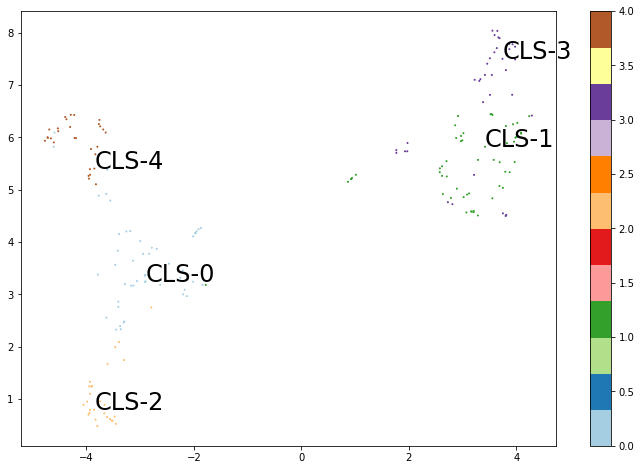

In [17]:
tm.run_topic_modeling("distiluse-base-multilingual-cased-v1")




 TRANSFER LEARNING = model selection
distiluse-base-multilingual-cased-v2


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)


 CORPUS EMBEDDING
(198, 512)
[[-0.07737382 -0.0566071  -0.02118554 ... -0.05217161  0.00590877
   0.01268494]
 [-0.01084084  0.02079264 -0.0629609  ... -0.03557485  0.03239493
   0.03764724]
 [-0.06548979 -0.07998324  0.0180215  ... -0.03896013  0.06660201
   0.00314809]
 ...
 [-0.03426241  0.01829544  0.00726306 ... -0.00229641 -0.01683454
  -0.02943926]
 [ 0.01442421  0.00195536 -0.05648366 ...  0.01459479  0.06160651
  -0.01301331]
 [ 0.02762303 -0.00909271 -0.03813926 ...  0.02010661  0.03103782
  -0.05121202]]


 (I) Topic Modeling

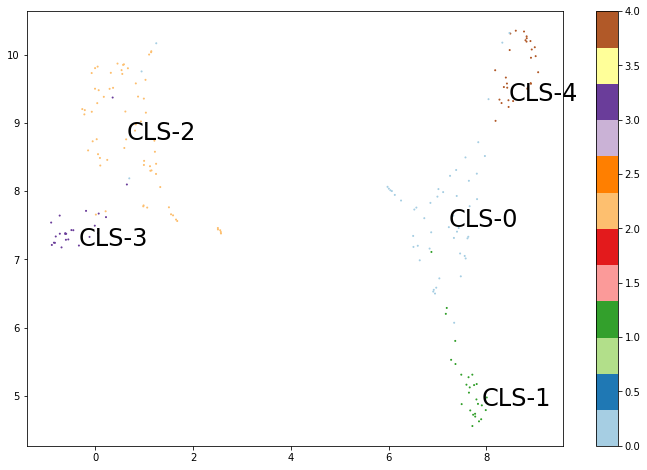

In [18]:
tm.run_topic_modeling("distiluse-base-multilingual-cased-v2")
